# Homework Assignment 1

In [83]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

## 1. Created new s3 bucket: data-448-bucket-callaghan
## Using pandas to read the data files

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [84]:
## 2. Reporting the number of observations in the train and test data-frames

print("Train dimensions:", train.shape)
print("Test dimensions:", test.shape)

## Creating a frequency table of the target variable (fraud)

print('\nNumber of fraud in training set:\n', train['fraud'].value_counts())

## Relative frequencies
print('\nRelative proportion of fraud in training set:\n', train['fraud'].value_counts() / train.shape[0])

Train dimensions: (1879, 10)
Test dimensions: (498121, 9)

Number of fraud in training set:
 0    1775
1     104
Name: fraud, dtype: int64

Relative proportion of fraud in training set:
 0    0.944651
1    0.055349
Name: fraud, dtype: float64


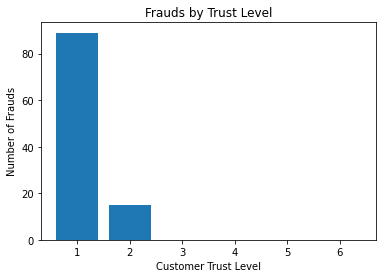

In [85]:
## 3. a) Visualization 1 -- Bar plot of total number of frauds for each "Trust Level" group

trust = train.groupby('trustLevel').sum()

fig = plt.figure()
plt.bar(trust.index, trust['fraud'])
plt.title('Frauds by Trust Level')
plt.xlabel('Customer Trust Level')
plt.ylabel('Number of Frauds')
plt.show()

## Clearly, we can see that the higher customer trust scores have no fraud transactions. All frauds
## are made up of customers with a trust score of 1 or 2. This seems to be an important variable for
## fraud detection.

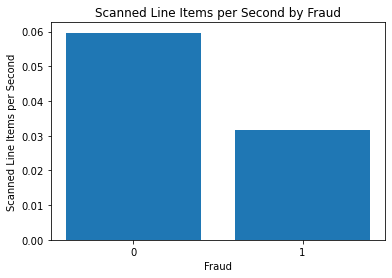

In [87]:
## 3. b) Visualization 2 -- Bar plot of average number of scanned products between fraud and 
## not fraud transactions

train['fraud'] = np.where(train['fraud'] == 0, '0', '1')

average = train.groupby('fraud').mean()

fig = plt.figure()
plt.bar(average.index, average['scannedLineItemsPerSecond'])
plt.title('Average Scanned Line Items per Second by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Average Scanned Line Items per Second')
plt.show()

## Here, we can see that for fraud transactions, the average number of scanned items per second is about 
## 50% less than the average number of scanned items per second for non-fraud transactions. This seems to 
## be an important variable for fraud detection. Clearly, the customers committing fraud are, on average, 
## scanning less items per second. 

In [9]:
## 3. Creating at least two visualizations that may show interesting relationships between the
input variables and the target variable. Make sure to describe the visualizations.

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526
